In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive, files

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Downloading GloVe (Global Vectors for Word Representation)
!wget http://nlp.stanford.edu/data/glove.6B.zip
# Unzip, create folders and move glove.6B.300d.txt to drive
!unzip glove.6B.zip
! mkdir -p 'drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/glove'
! mkdir -p 'drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/TREC Dataset'
! mkdir -p 'drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/models'
! mv glove.6B.300d.txt 'drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/glove'
# Delete irrelevant files
! rm glove*
# Get the data set from the user
print('Upload TREC Dataset files:')
_ = files.upload()
# Move dataset to drive
! mv QA_data.csv 'drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/TREC Dataset'
! mv test.csv 'drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/TREC Dataset'
! mv train.csv 'drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/TREC Dataset'

--2023-12-07 12:54:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-12-07 12:54:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-12-07 12:54:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Saving QA_data.csv to QA_data.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


# Preprocessing

In [ ]:
def remove_special_characters(string):
    return re.sub(r"[^a-zA-Z0-9?]", " ", string)
def sentence_prep(sentence):
    # Tokenize the sentence into individual words
    tokens = word_tokenize(remove_special_characters(sentence))
    # Initialize the WordNetLemmatizer object for lemmatization
    wln = WordNetLemmatizer()
    # Normalize tokenized words by stemming or lemmatization
    normalized_tokens = []
    for token in tokens:
        normalized_token = wln.lemmatize(token.lower())
        normalized_tokens.append(normalized_token)
    return normalized_tokens

In [ ]:
# Download the necessary nltk data
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Create a dictionary of words and their corresponding vectors
path_to_glove_file = 'drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/glove/glove.6B.300d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# Tokenize the data
data_train_pd = pd.read_csv('drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/TREC Dataset/train.csv')
data_train_np = data_train_pd.to_numpy()
for row in data_train_np:
    row[2] = sentence_prep(row[2])
np.random.shuffle(data_train_np)

data_test_pd = pd.read_csv('drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/TREC Dataset/test.csv')
data_test_np = data_test_pd.to_numpy()
for row in data_test_np:
    row[2] = sentence_prep(row[2])
np.random.shuffle(data_test_np)

In [ ]:
# Find and remove unknown words that are not in the GloVe
unknown_words = []
total_words = 0

def find_unknown_words(words):

    global total_words
    total_words = total_words + len(words)
    has_unknown = False
    for word in words:
        if not (word in embeddings_index):
            unknown_words.append(word)
            has_unknown = True
            words.remove(word)
    # if has_unknown:
    #     return words
    return words
for i in range(3):
    unknown_words = []
    total_words = 0
    for row in data_test_np:
        find_unknown_words(row[2])
    print( f'{len(unknown_words)/total_words*100:5.2} % of test words are unknown' )

    unknown_words = []
    total_words = 0
    for row in data_train_np:
        find_unknown_words(row[2])
    print( f'{len(unknown_words)/total_words*100:5.2} % of train words are unknown' )

 0.08 % of test words are unknown
  0.4 % of train words are unknown
  0.0 % of test words are unknown
0.015 % of train words are unknown
  0.0 % of test words are unknown
  0.0 % of train words are unknown


In [ ]:
# Find how many words are in the longest sentence
longest = 0
for i in range(data_train_np.shape[0]):
    length = len(data_train_np[i,2])
    if length > longest:
        longest = length
print(longest)

33


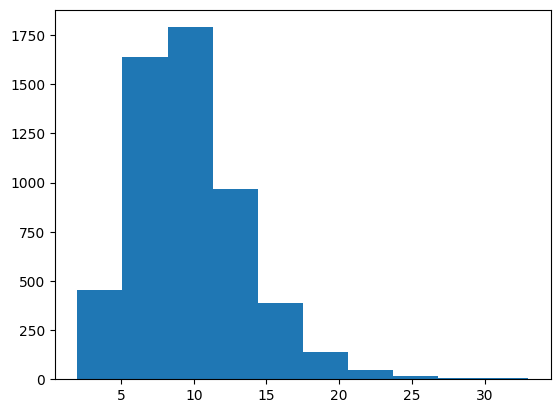

for train data; median =  9.0 min =  2.0 max =  33.0


In [ ]:
# Create a histogram of the length of the training sentences
lengths = np.zeros(data_train_np.shape[0])
for i in range(data_train_np.shape[0]):
    lengths[i] = len(data_train_np[i,2])

plt.hist(lengths)
plt.show()
median = np.median(lengths)
print('for train data; median = ', median,'min = ',np.min(lengths),'max = ',np.max(lengths))

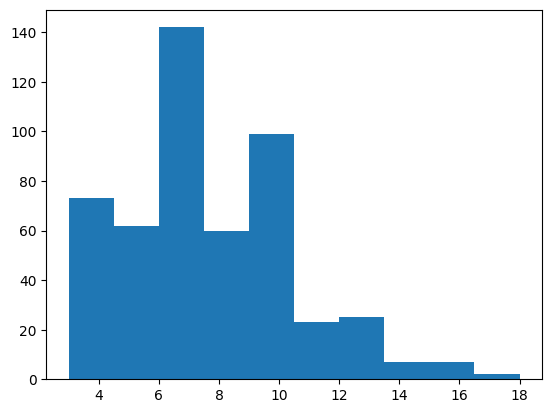

for test data; median =  7.0 min =  3.0 max =  18.0


In [ ]:
# Create a histogram of the length of the test sentences
lengths = np.zeros(data_test_np.shape[0])
for i in range(data_test_np.shape[0]):
    lengths[i] = len(data_test_np[i,2])

plt.hist(lengths)
plt.show()
print('for test data; median = ', np.median(lengths),'min = ',np.min(lengths),'max = ',np.max(lengths))

In [ ]:
device = 'cuda:0'
torch.cuda.empty_cache()
size_of_all = 15

In [ ]:
# Convert train data to tensor
X_train = np.zeros((data_train_np.shape[0],int(size_of_all),300))
y_train = np.zeros((data_train_np.shape[0],2))
for i in range(data_train_np.shape[0]):
    words = np.array(list(map(lambda i: embeddings_index[i], data_train_np[i,2])))
    X_train[i,-len(words):,:] = words[-int(size_of_all):]
    y_train[i,0] = data_train_np[i,0]
    y_train[i,1] = data_train_np[i,1]
X_train_tensor = torch.tensor(X_train, device=device, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, device=device).type(torch.LongTensor).to(device)

In [ ]:
# Convert test data to tensor
X_test = np.zeros((data_test_np.shape[0],int(size_of_all),300))
y_test = np.zeros((data_test_np.shape[0],2))
for i in range(data_test_np.shape[0]):
    words = np.array(list(map(lambda i: embeddings_index[i], data_test_np[i,2])))
    X_test[i,-len(words):,:] = words[-int(size_of_all):]
    y_test[i,0] = data_test_np[i,0]
    y_test[i,1] = data_test_np[i,1]
X_test_tensor = torch.tensor(X_test, device=device, dtype=torch.float).to(device)
y_test_tensor = torch.tensor(y_test, device=device).type(torch.LongTensor).to(device)

In [ ]:
# Count the number of data in each main class
unique, counts = np.unique(data_train_np[:,0], return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4, 5], dtype=object),
 array([1162, 1250,   86, 1223,  896,  835]))

In [ ]:
# Define the weight of each main class to use in the criterion
weights = np.zeros(len(counts))
for i in range(len(counts)):
    weights[i] = 1- (counts[i]/counts.sum())

weights = torch.tensor(weights, device=device, dtype=torch.float)

In [ ]:
# Count the number of data in each sub class
unique_sub, counts_sub = np.unique(data_train_np[:,1], return_counts=True)
unique_sub, counts_sub

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], dtype=object),
 array([276, 207, 112,  70, 962, 189,  25, 421, 218, 191,  56,  66, 321,
        363, 733,   9,   4, 103, 155,  40,  93, 129,  16, 103,  21,  71,
         42,  75,  41,  62,  13,  38,  13,  10,  16,   9,  26,  16,  27,
          9,  34,   8,  11,   6,  27,  11,   4]))

In [ ]:
# Define the weight of each sub class to use in the criterion
weights_sub = np.zeros(len(counts_sub))
for i in range(len(counts_sub)):
    weights_sub[i] = 1- (counts_sub[i]/counts_sub.sum())

weights_sub = torch.tensor(weights_sub, device=device, dtype=torch.float)

In [ ]:
X_train_tensor.shape[1]

15

# Training

In [ ]:
torch.cuda.empty_cache()

In [ ]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.input_size, self.hidden_size
                            , self.num_layers, batch_first=True)
        self.classifier = nn.Sequential( nn.Linear(self.hidden_size, 128)
                                       ,nn.ReLU()
                                        ,nn.Linear(128, 32)
                                        ,nn.ReLU()
                                        ,nn.Linear(32, 6))

        self.softmax = nn.Softmax(-1)

    def forward(self, x):
        x, (hidden, _) = self.lstm(x)
        x = self.classifier(x[:,-1,:])
        x = self.softmax( x )
        return x

## model 1, h = 25

In [ ]:
hidden_size = 25
input_size = 300
num_layers = 1
lr = 0.001
batch_size = 25
torch.manual_seed(40)
# Initialize the model, the optimizer and criterion
model_1_25 = LSTMNetwork(input_size, hidden_size, num_layers)
model_1_25 = model_1_25.to(device)
optimizer = optim.Adam(model_1_25.parameters(), lr=lr)
# lr_scheduler = optim.lr_scheduler.LinearLR(optimizer,gamma=0.99)
criterion = nn.CrossEntropyLoss(weight=weights)

train_loss = np.zeros((0))
train_acc = np.zeros((0))
test_loss = np.zeros((0))
test_acc = np.zeros((0))
total_epoch_counter = 0
total_epoch = 0
sparse_epochs = np.zeros((0))
loader_size = len(X_train_tensor)//batch_size
output_accumul = torch.zeros((loader_size*batch_size,6))

In [ ]:
num_epochs = 100
total_epoch += num_epochs
train_loss = np.concatenate((train_loss, np.zeros((num_epochs))), )
test_loss = np.concatenate((test_loss, np.zeros((num_epochs))), )
train_acc = np.concatenate((train_acc, np.zeros((num_epochs))), )
test_acc = np.concatenate((test_acc, np.zeros((num_epochs))), )
sparse_epochs = np.concatenate((sparse_epochs, np.zeros((num_epochs))), )
actual_labels = y_train_tensor[:loader_size*batch_size,0].detach().cpu().numpy()

for epoch in range(num_epochs):
    model_1_25.train()
    total_loss = 0
    for i in range(loader_size):
        input_data = X_train_tensor[i*batch_size:(i+1)*batch_size]
        target = y_train_tensor[i*batch_size:(i+1)*batch_size,0]
        optimizer.zero_grad()
        outputs = model_1_25(input_data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        output_accumul[i*batch_size:(i+1)*batch_size] = outputs
        total_loss += loss

    total_loss /= loader_size
    with torch.inference_mode():
        test_outputs = model_1_25(X_test_tensor)
        t_loss = criterion(test_outputs, y_test_tensor[:,0])

    train_loss[total_epoch_counter] = total_loss.detach().cpu().numpy()
    test_loss[total_epoch_counter] = t_loss.detach().cpu().numpy()
    if (epoch+1) % 1 == 0:
        predictions = [torch.argmax(i).detach().cpu().numpy() for i in output_accumul]
        accuracy = (np.array(predictions) == actual_labels).sum() / len(predictions)
        train_acc[total_epoch_counter] = accuracy
        sparse_epochs[total_epoch_counter] = total_epoch_counter+1

        predictions = [torch.argmax(i).detach().cpu().numpy() for i in test_outputs]
        actual_labels_test =  y_test_tensor[:,0].detach().cpu().numpy()
        test_accuracy = (np.array(predictions) == actual_labels_test).sum() / len(predictions)
        test_acc[total_epoch_counter] = test_accuracy
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Train loss: {:.4f}, lr: {:.7f}, accuracy: {:.4f}'
                   .format(total_epoch_counter+1, total_epoch, train_loss[total_epoch_counter], lr, accuracy))
    total_epoch_counter += 1

Epoch [10/100], Train loss: 1.2279, lr: 0.0010000, accuracy: 0.8180
Epoch [20/100], Train loss: 1.1774, lr: 0.0010000, accuracy: 0.8686
Epoch [30/100], Train loss: 1.1642, lr: 0.0010000, accuracy: 0.8820
Epoch [40/100], Train loss: 1.1448, lr: 0.0010000, accuracy: 0.9015
Epoch [50/100], Train loss: 1.1342, lr: 0.0010000, accuracy: 0.9123
Epoch [60/100], Train loss: 1.1256, lr: 0.0010000, accuracy: 0.9207
Epoch [70/100], Train loss: 1.1223, lr: 0.0010000, accuracy: 0.9239
Epoch [80/100], Train loss: 1.1219, lr: 0.0010000, accuracy: 0.9242
Epoch [90/100], Train loss: 1.1175, lr: 0.0010000, accuracy: 0.9290
Epoch [100/100], Train loss: 1.1126, lr: 0.0010000, accuracy: 0.9338


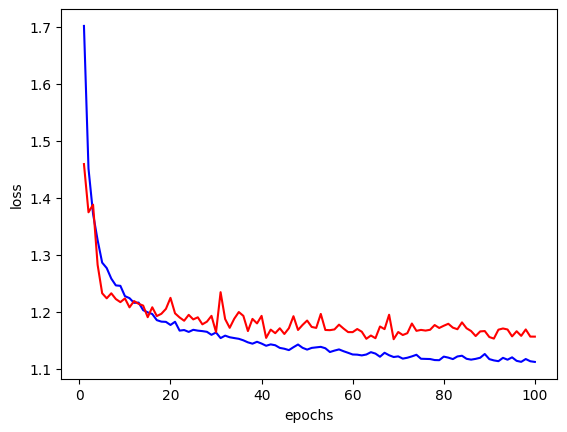

In [ ]:
x = np.arange(1,len(train_loss)+1)
plt.plot(x, train_loss, 'b')
plt.plot(x, test_loss, 'r')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

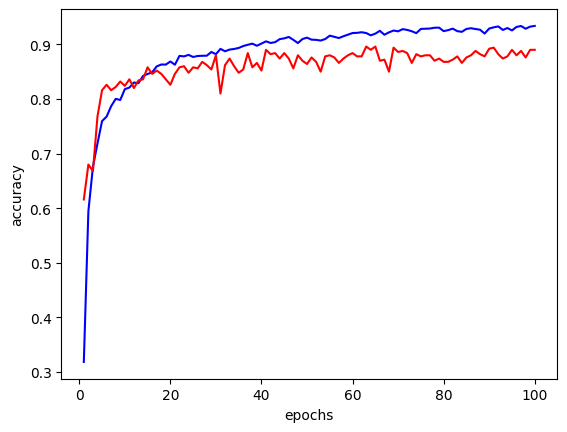

In [ ]:
plt.plot(sparse_epochs, train_acc, 'b')
plt.plot(sparse_epochs, test_acc, 'r')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

<Axes: >

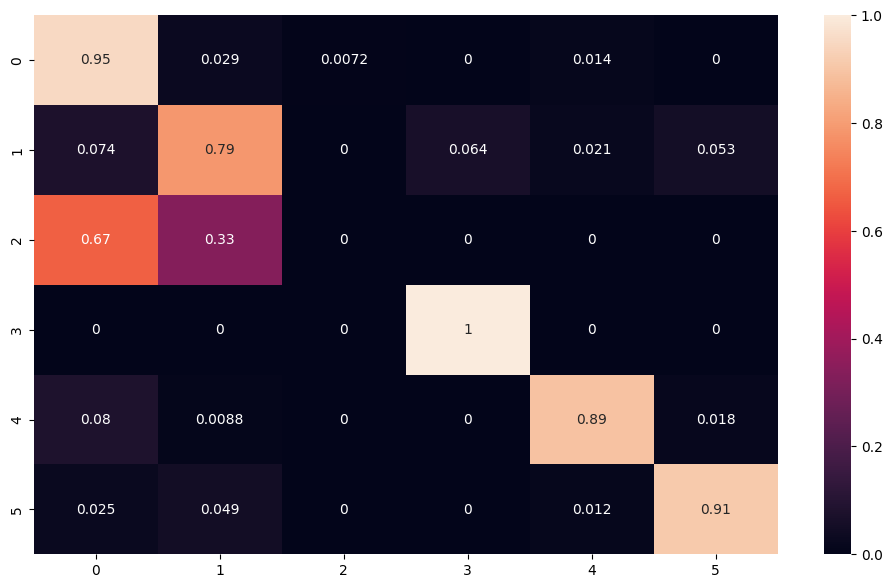

In [ ]:
with torch.inference_mode():
    test_outputs = model_1_25(X_test_tensor)
    t_loss = criterion(test_outputs, y_test_tensor[:,0])
predictions = [torch.argmax(i).detach().cpu().numpy() for i in test_outputs]
predictions = np.array(predictions)
actual_labels =  y_test_tensor[:,0].detach().cpu().numpy()
conf_mat = confusion_matrix(actual_labels, predictions)
df_cm = pd.DataFrame(conf_mat / np.sum(conf_mat, axis=1)[:, None],
                     index = [0,1,2,3,4,5], columns = [0,1,2,3,4,5])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
print(classification_report(actual_labels, predictions))

              precision    recall  f1-score   support

           0       0.85      0.95      0.89       138
           1       0.86      0.79      0.82        94
           2       0.00      0.00      0.00         9
           3       0.92      1.00      0.96        65
           4       0.95      0.89      0.92       113
           5       0.91      0.91      0.91        81

    accuracy                           0.89       500
   macro avg       0.75      0.76      0.75       500
weighted avg       0.88      0.89      0.88       500



In [ ]:
torch.save(model_1_25.state_dict(), 'drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/models/model_1_25_ch8.pth')

## model 1, h = 100

In [ ]:
hidden_size = 100
input_size = 300
num_layers = 1
lr = 0.001
batch_size = 20
torch.manual_seed(40)
# Initialize the model, the optimizer and criterion
model_1_100 = LSTMNetwork(input_size, hidden_size, num_layers)
model_1_100 = model_1_100.to(device)
optimizer = optim.Adam(model_1_100.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(weight=weights)

train_loss = np.zeros((0))
train_acc = np.zeros((0))
test_loss = np.zeros((0))
test_acc = np.zeros((0))
total_epoch_counter = 0
total_epoch = 0
sparse_epochs = np.zeros((0))
# loss_prev = 99999999 #initialized as inf
# sign = 0
loader_size = len(X_train_tensor)//batch_size
actual_labels = y_train_tensor[:loader_size*batch_size,0].detach().cpu().numpy()
output_accumul = torch.zeros((loader_size*batch_size,6))

In [ ]:
num_epochs = 100
total_epoch += num_epochs
train_loss = np.concatenate((train_loss, np.zeros((num_epochs))), )
test_loss = np.concatenate((test_loss, np.zeros((num_epochs))), )
train_acc = np.concatenate((train_acc, np.zeros((num_epochs))), )
test_acc = np.concatenate((test_acc, np.zeros((num_epochs))), )
sparse_epochs = np.concatenate((sparse_epochs, np.zeros((num_epochs))), )

for epoch in range(num_epochs):
    model_1_100.train()
    total_loss = 0
    for i in range(loader_size):
        input_data = X_train_tensor[i*batch_size:(i+1)*batch_size]
        target = y_train_tensor[i*batch_size:(i+1)*batch_size,0]
        optimizer.zero_grad()
        outputs = model_1_100(input_data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        output_accumul[i*batch_size:(i+1)*batch_size] = outputs
        total_loss += loss

    total_loss /= loader_size
    with torch.inference_mode():
        test_outputs = model_1_100(X_test_tensor)
        t_loss = criterion(test_outputs, y_test_tensor[:,0])

    train_loss[total_epoch_counter] = total_loss.detach().cpu().numpy()
    test_loss[total_epoch_counter] = t_loss.detach().cpu().numpy()
    if (epoch+1) % 1 == 0:
        predictions = [torch.argmax(i).detach().cpu().numpy() for i in output_accumul]
        accuracy = (np.array(predictions) == actual_labels).sum() / len(predictions)
        train_acc[total_epoch_counter] = accuracy
        sparse_epochs[total_epoch_counter] = total_epoch_counter+1

        predictions = [torch.argmax(i).detach().cpu().numpy() for i in test_outputs]
        actual_labels_test =  y_test_tensor[:,0].detach().cpu().numpy()
        test_accuracy = (np.array(predictions) == actual_labels_test).sum() / len(predictions)
        test_acc[total_epoch_counter] = test_accuracy
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Train loss: {:.4f}, lr: {:.7f}, accuracy: {:.4f}'
                   .format(total_epoch_counter+1, total_epoch, train_loss[total_epoch_counter], lr, accuracy))
    total_epoch_counter += 1

Epoch [10/100], Train loss: 1.2221, lr: 0.0010000, accuracy: 0.8217
Epoch [20/100], Train loss: 1.1906, lr: 0.0010000, accuracy: 0.8542
Epoch [30/100], Train loss: 1.1748, lr: 0.0010000, accuracy: 0.8708
Epoch [40/100], Train loss: 1.1484, lr: 0.0010000, accuracy: 0.8980
Epoch [50/100], Train loss: 1.1358, lr: 0.0010000, accuracy: 0.9110
Epoch [60/100], Train loss: 1.1343, lr: 0.0010000, accuracy: 0.9121
Epoch [70/100], Train loss: 1.1302, lr: 0.0010000, accuracy: 0.9149
Epoch [80/100], Train loss: 1.1134, lr: 0.0010000, accuracy: 0.9313
Epoch [90/100], Train loss: 1.1131, lr: 0.0010000, accuracy: 0.9314
Epoch [100/100], Train loss: 1.1109, lr: 0.0010000, accuracy: 0.9333


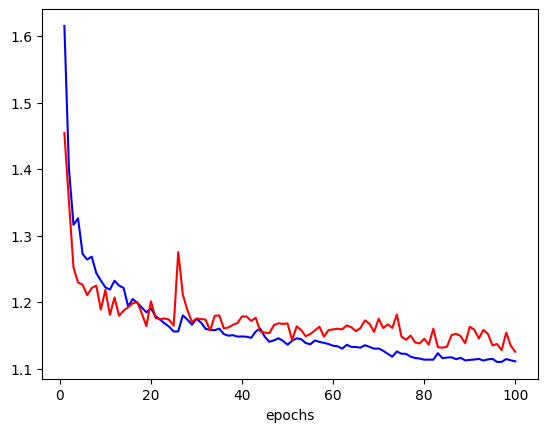

In [ ]:
x = np.arange(1,len(train_loss)+1)
plt.plot(x, train_loss, 'b')
plt.plot(x, test_loss, 'r')
plt.xlabel('epochs')
plt.show()

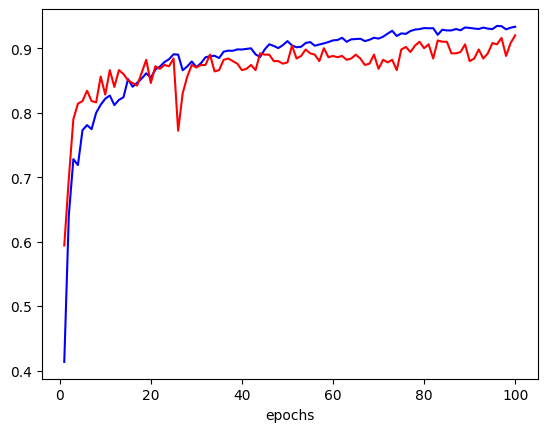

In [ ]:
plt.plot(sparse_epochs, train_acc, 'b')
plt.plot(sparse_epochs, test_acc, 'r')
plt.xlabel('epochs')
plt.show()

<Axes: >

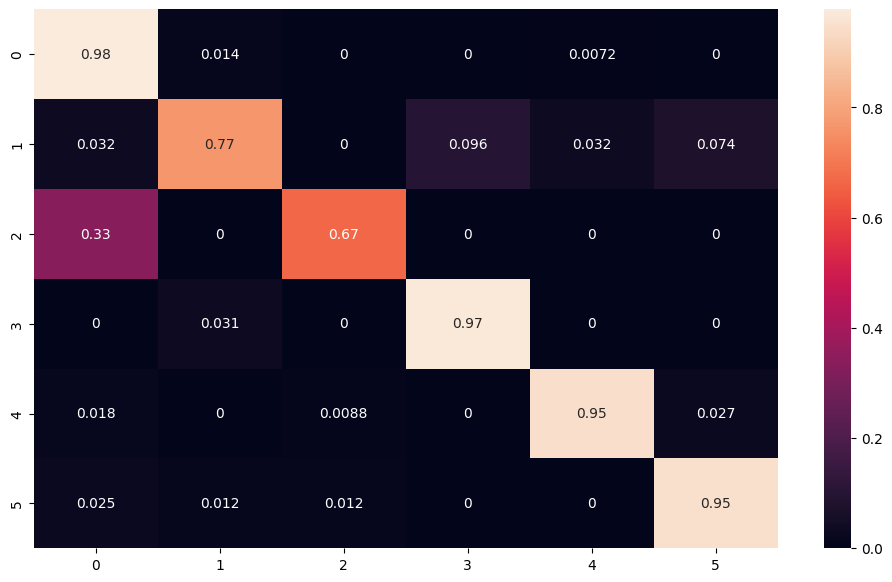

In [ ]:
with torch.inference_mode():
    test_outputs = model_1_100(X_test_tensor)
    t_loss = criterion(test_outputs, y_test_tensor[:,0])
predictions = [torch.argmax(i).detach().cpu().numpy() for i in test_outputs]
predictions = np.array(predictions)
actual_labels =  y_test_tensor[:,0].detach().cpu().numpy()
conf_mat = confusion_matrix(actual_labels, predictions)
df_cm = pd.DataFrame(conf_mat / np.sum(conf_mat, axis=1)[:, None],
                     index = [0,1,2,3,4,5], columns = [0,1,2,3,4,5])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
print(classification_report(actual_labels, predictions))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       138
           1       0.94      0.77      0.84        94
           2       0.75      0.67      0.71         9
           3       0.88      0.97      0.92        65
           4       0.96      0.95      0.96       113
           5       0.89      0.95      0.92        81

    accuracy                           0.92       500
   macro avg       0.89      0.88      0.88       500
weighted avg       0.92      0.92      0.92       500



In [ ]:
torch.save(model_1_100.state_dict(), 'drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/models/model_1_100_ch8.pth')

## model 2, h = 25

In [ ]:
class LSTMNetwork2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.input_size, self.hidden_size
                            , self.num_layers, batch_first=True)
        self.classifier = nn.Sequential( nn.Linear(self.hidden_size, 128)
                                        ,nn.ReLU()
                                        ,nn.Linear(128, 32)
                                        ,nn.ReLU()
                                        ,nn.Linear(32, 6))
        self.classifier2 = nn.Sequential( nn.Linear(self.hidden_size, 256)
                                        ,nn.ReLU()
                                        ,nn.Linear(256, 64)
                                        ,nn.ReLU()
                                        ,nn.Linear(64, 47))
        self.softmax = nn.Softmax(-1)

    def forward(self, x):
        output, (hidden, _) = self.lstm(x)
        x = self.classifier(output[:,-2,:])
        x = self.softmax( x )
        y = self.classifier2(output[:,-1,:])
        y = self.softmax( y )
        two_mlp_outputs = torch.concat((y,x),dim=1)
        return two_mlp_outputs

In [ ]:
device = 'cuda'
weights_sub = weights_sub.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [ ]:
torch.cuda.empty_cache()

# load model from local storage
hidden_size = 25
input_size = 300
num_layers = 1
lr = 0.001
batch_size = 10

torch.manual_seed(40)
# Initialize the model, the optimizer and criterion
model_2_25 = LSTMNetwork2(input_size, hidden_size, num_layers)
model_2_25 = model_2_25.to(device)
optimizer = optim.Adam(model_2_25.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(weight=weights)
criterion_sub = nn.CrossEntropyLoss(weight=weights_sub)

train_loss = np.zeros((0))
train_acc = np.zeros((0))
test_loss = np.zeros((0))
test_acc = np.zeros((0))
train_loss_sub = np.zeros((0))
train_acc_sub = np.zeros((0))
test_loss_sub = np.zeros((0))
test_acc_sub = np.zeros((0))
total_epoch_counter = 0
total_epoch = 0
sparse_epochs = np.zeros((0))
loader_size = len(X_train_tensor)//batch_size
actual_labels_sub = y_train_tensor[:loader_size*batch_size,1].detach().cpu().numpy()
actual_labels_test_sub =  y_test_tensor[:,1].detach().cpu().numpy()
actual_labels = y_train_tensor[:loader_size*batch_size,0].detach().cpu().numpy()
actual_labels_test =  y_test_tensor[:,0].detach().cpu().numpy()
output_accumul_sub = torch.zeros((loader_size*batch_size,47))
output_accumul = torch.zeros((loader_size*batch_size,6))

In [ ]:
num_epochs = 200
total_epoch += num_epochs
train_loss = np.concatenate((train_loss, np.zeros((num_epochs))), )
test_loss = np.concatenate((test_loss, np.zeros((num_epochs))), )
train_acc = np.concatenate((train_acc, np.zeros((num_epochs))), )
test_acc = np.concatenate((test_acc, np.zeros((num_epochs))), )
train_loss_sub = np.concatenate((train_loss_sub, np.zeros((num_epochs))), )
test_loss_sub = np.concatenate((test_loss_sub, np.zeros((num_epochs))), )
train_acc_sub = np.concatenate((train_acc_sub, np.zeros((num_epochs))), )
test_acc_sub = np.concatenate((test_acc_sub, np.zeros((num_epochs))), )
sparse_epochs = np.concatenate((sparse_epochs, np.zeros((num_epochs))), )

for epoch in range(num_epochs):
    model_2_25.train()
    total_loss = 0
    total_loss_sub = 0
    for i in range(loader_size):
        input_data = X_train_tensor[i*batch_size:(i+1)*batch_size]
        target_sub = y_train_tensor[i*batch_size:(i+1)*batch_size,1]
        optimizer.zero_grad()
        outputs_sub = model_2_25(input_data)[:,:47]
        loss_sub = criterion_sub(outputs_sub, target_sub)
        loss_sub.backward()
        optimizer.step()
        output_accumul_sub[i*batch_size:(i+1)*batch_size] = outputs_sub
        total_loss_sub += loss_sub

        target = y_train_tensor[i*batch_size:(i+1)*batch_size,0]
        optimizer.zero_grad()
        outputs = model_2_25(input_data)[:,47:]
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        output_accumul[i*batch_size:(i+1)*batch_size] = outputs
        total_loss += loss

    total_loss_sub /= loader_size
    total_loss /= loader_size
    with torch.inference_mode():
        test_outputs = model_2_25(X_test_tensor)
        t_loss_sub = criterion_sub(test_outputs[:,:47], y_test_tensor[:,1])
        t_loss = criterion(test_outputs[:,47:], y_test_tensor[:,0])

    train_loss_sub[total_epoch_counter] = total_loss_sub.detach().cpu().numpy()
    test_loss_sub[total_epoch_counter] = t_loss_sub.detach().cpu().numpy()
    train_loss[total_epoch_counter] = total_loss.detach().cpu().numpy()
    test_loss[total_epoch_counter] = t_loss.detach().cpu().numpy()
    if (epoch+1) % 1 == 0:
        predictions_sub = [torch.argmax(i).detach().cpu().numpy() for i in output_accumul_sub]
        accuracy_sub = (np.array(predictions_sub) == actual_labels_sub).sum() / len(predictions_sub)
        train_acc_sub[total_epoch_counter] = accuracy_sub
        predictions_test_sub = [torch.argmax(i).detach().cpu().numpy() for i in test_outputs[:,:47]]
        test_accuracy_sub = (np.array(predictions_test_sub) == actual_labels_test_sub).sum() / len(predictions_test_sub)
        test_acc_sub[total_epoch_counter] = test_accuracy_sub

        predictions = [torch.argmax(i).detach().cpu().numpy() for i in output_accumul]
        accuracy = (np.array(predictions) == actual_labels).sum() / len(predictions)
        train_acc[total_epoch_counter] = accuracy
        predictions_test = [torch.argmax(i).detach().cpu().numpy() for i in test_outputs[:,47:]]
        test_accuracy = (np.array(predictions_test) == actual_labels_test).sum() / len(predictions_test)
        test_acc[total_epoch_counter] = test_accuracy

        sparse_epochs[total_epoch_counter] = total_epoch_counter+1
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Train loss: {:.4f}, lr: {:.7f}, main accuracy: {:.4f}, sub accuracy: {:.4f}'
                   .format(total_epoch_counter+1, total_epoch, train_loss[total_epoch_counter]
                           , lr, accuracy, accuracy_sub))
    total_epoch_counter += 1

Epoch [10/200], Train loss: 1.1907, lr: 0.0010000, main accuracy: 0.8541, sub accuracy: 0.3804
Epoch [20/200], Train loss: 1.1459, lr: 0.0010000, main accuracy: 0.8993, sub accuracy: 0.4530
Epoch [30/200], Train loss: 1.1219, lr: 0.0010000, main accuracy: 0.9244, sub accuracy: 0.4859
Epoch [40/200], Train loss: 1.1160, lr: 0.0010000, main accuracy: 0.9299, sub accuracy: 0.5018
Epoch [50/200], Train loss: 1.1127, lr: 0.0010000, main accuracy: 0.9334, sub accuracy: 0.5206
Epoch [60/200], Train loss: 1.1030, lr: 0.0010000, main accuracy: 0.9420, sub accuracy: 0.5516
Epoch [70/200], Train loss: 1.0983, lr: 0.0010000, main accuracy: 0.9464, sub accuracy: 0.5547
Epoch [80/200], Train loss: 1.0933, lr: 0.0010000, main accuracy: 0.9523, sub accuracy: 0.5611
Epoch [90/200], Train loss: 1.0950, lr: 0.0010000, main accuracy: 0.9495, sub accuracy: 0.5642
Epoch [100/200], Train loss: 1.0875, lr: 0.0010000, main accuracy: 0.9572, sub accuracy: 0.5659
Epoch [110/200], Train loss: 1.0838, lr: 0.001000

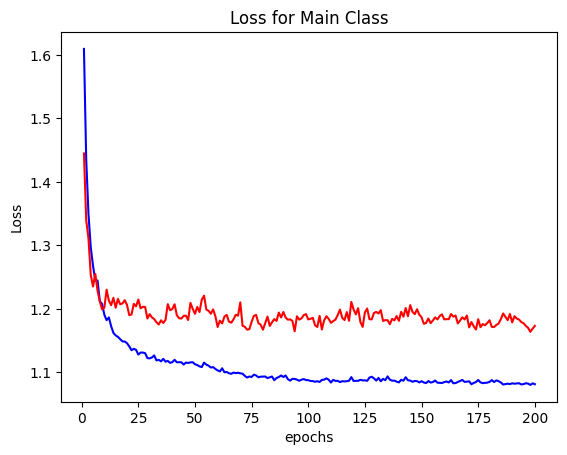

In [ ]:
x = np.arange(1,len(train_loss)+1)
plt.plot(x, train_loss, 'b')
plt.plot(x, test_loss, 'r')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss for Main Class')
plt.show()

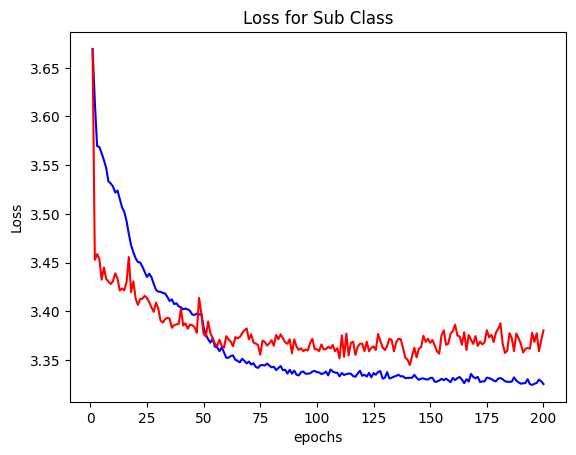

In [ ]:
x = np.arange(1,len(train_loss_sub)+1)
plt.plot(x, train_loss_sub, 'b')
plt.plot(x, test_loss_sub, 'r')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss for Sub Class')
plt.show()

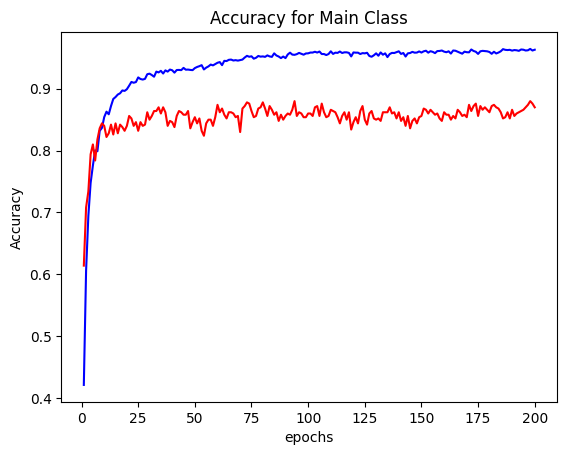

In [ ]:
plt.plot(sparse_epochs, train_acc, 'b')
plt.plot(sparse_epochs, test_acc, 'r')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for Main Class')
plt.show()

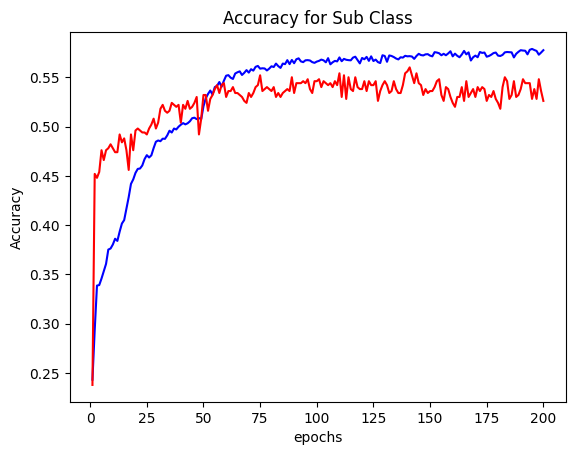

In [ ]:
plt.plot(sparse_epochs, train_acc_sub, 'b')
plt.plot(sparse_epochs, test_acc_sub, 'r')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for Sub Class')
plt.show()

<ipython-input-53-473b324521aa>:17: RuntimeWarning: invalid value encountered in divide
  df_cm_sub = pd.DataFrame(conf_mat_sub / np.sum(conf_mat_sub, axis=1)[:, None],)


<Axes: >

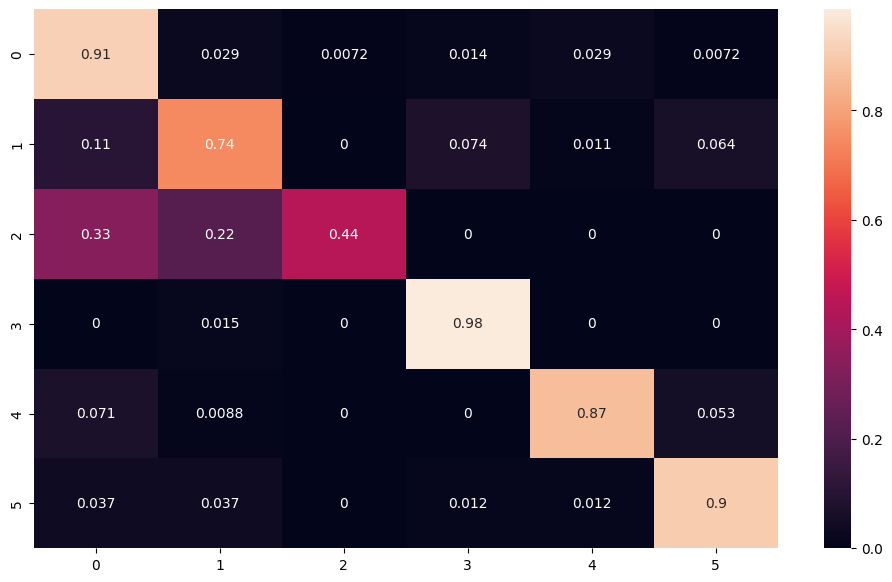

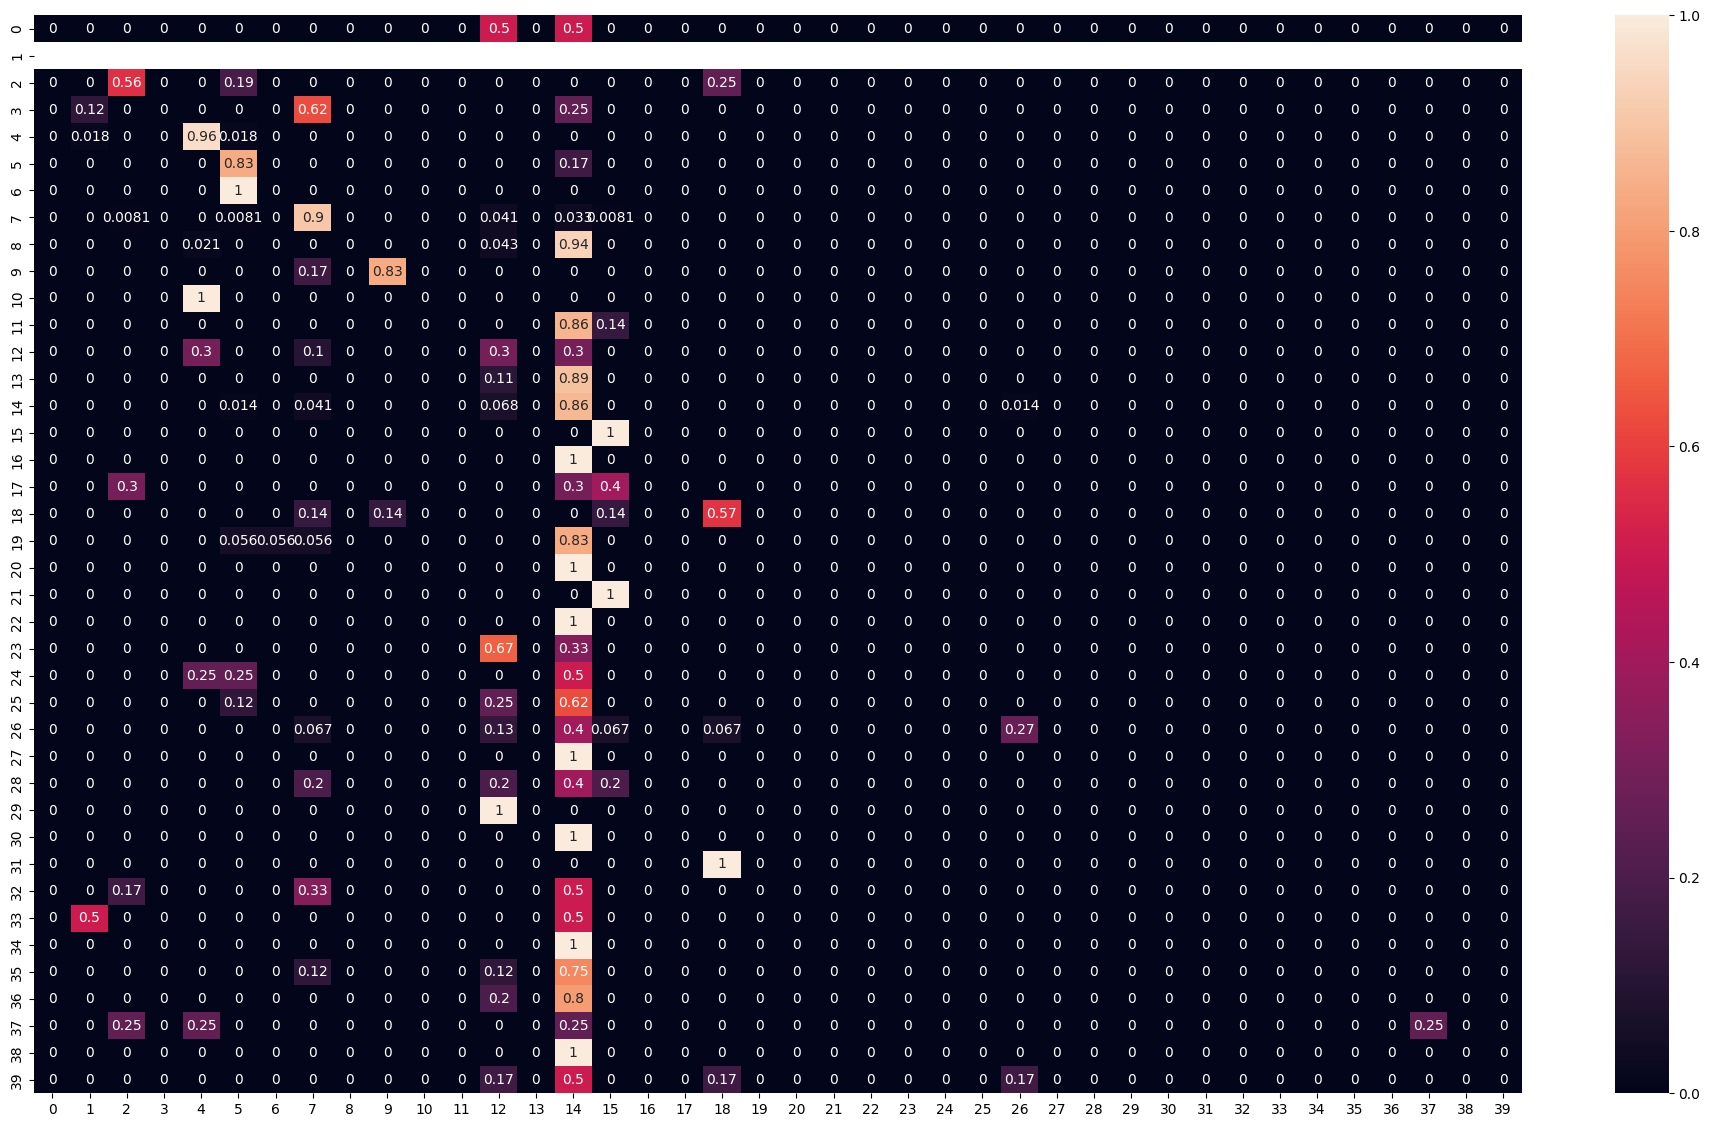

In [ ]:
with torch.inference_mode():
    test_outputs = model_2_25(X_test_tensor)
    # t_loss = criterion(test_outputs, y_test_tensor[:,1])
predictions_b = [torch.argmax(i).detach().cpu().numpy() for i in test_outputs[:,47:]]
predictions_b = np.array(predictions_b)
actual_labels_b =  y_test_tensor[:,0].cpu().numpy()
conf_mat = confusion_matrix(actual_labels_b, predictions_b)
df_cm = pd.DataFrame(conf_mat / np.sum(conf_mat, axis=1)[:, None],)
                     # index = [i for i in range(47)], columns = [i for i in range(47)])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

predictions_sub_b = [torch.argmax(i).detach().cpu().numpy() for i in test_outputs[:,:47]]
predictions_sub_b = np.array(predictions_sub_b)
actual_labels_sub_b =  y_test_tensor[:,1].cpu().numpy()
conf_mat_sub = confusion_matrix(actual_labels_sub_b, predictions_sub_b)
df_cm_sub = pd.DataFrame(conf_mat_sub / np.sum(conf_mat_sub, axis=1)[:, None],)
                     # index = [i for i in range(47)], columns = [i for i in range(47)])
plt.figure(figsize = (24,14))
sn.heatmap(df_cm_sub, annot=True)

In [ ]:
print(classification_report(actual_labels_b, predictions_b))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       138
           1       0.86      0.74      0.80        94
           2       0.80      0.44      0.57         9
           3       0.86      0.98      0.92        65
           4       0.94      0.87      0.90       113
           5       0.85      0.90      0.87        81

    accuracy                           0.87       500
   macro avg       0.86      0.81      0.82       500
weighted avg       0.87      0.87      0.87       500



In [ ]:
print(classification_report(actual_labels_sub_b, predictions_sub_b))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         0
           2       0.60      0.56      0.58        16
           3       0.00      0.00      0.00         8
           4       0.87      0.96      0.91        55
           5       0.33      0.83      0.48         6
           6       0.00      0.00      0.00         1
           7       0.86      0.90      0.88       123
           8       0.00      0.00      0.00        47
           9       0.83      0.83      0.83         6
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         7
          12       0.10      0.30      0.15        10
          13       0.00      0.00      0.00         9
          14       0.31      0.86      0.45        74
          17       0.27      1.00      0.42         4
          18       0.00      0.00      0.00         3
          19       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
torch.save(model_2_25.state_dict(), 'drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/models/model_2_25_ch7.pth')

## model 2, h = 100

In [ ]:
device = 'cuda'
weights_sub = weights_sub.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [ ]:
torch.cuda.empty_cache()

# load model from local storage
hidden_size = 100
input_size = 300
num_layers = 1
lr = 0.001
batch_size = 25

torch.manual_seed(40)
# Initialize the model, the optimizer and criterion
model_2_100 = LSTMNetwork2(input_size, hidden_size, num_layers)
model_2_100 = model_2_100.to(device)
optimizer = optim.Adam(model_2_100.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(weight=weights)
criterion_sub = nn.CrossEntropyLoss(weight=weights_sub)

train_loss = np.zeros((0))
train_acc = np.zeros((0))
test_loss = np.zeros((0))
test_acc = np.zeros((0))
train_loss_sub = np.zeros((0))
train_acc_sub = np.zeros((0))
test_loss_sub = np.zeros((0))
test_acc_sub = np.zeros((0))
total_epoch_counter = 0
total_epoch = 0
sparse_epochs = np.zeros((0))
loader_size = len(X_train_tensor)//batch_size
actual_labels_sub = y_train_tensor[:loader_size*batch_size,1].detach().cpu().numpy()
actual_labels_test_sub =  y_test_tensor[:,1].detach().cpu().numpy()
actual_labels = y_train_tensor[:loader_size*batch_size,0].detach().cpu().numpy()
actual_labels_test =  y_test_tensor[:,0].detach().cpu().numpy()
output_accumul_sub = torch.zeros((loader_size*batch_size,47))
output_accumul = torch.zeros((loader_size*batch_size,6))

In [ ]:
num_epochs = 200
total_epoch += num_epochs
train_loss = np.concatenate((train_loss, np.zeros((num_epochs))), )
test_loss = np.concatenate((test_loss, np.zeros((num_epochs))), )
train_acc = np.concatenate((train_acc, np.zeros((num_epochs))), )
test_acc = np.concatenate((test_acc, np.zeros((num_epochs))), )
train_loss_sub = np.concatenate((train_loss_sub, np.zeros((num_epochs))), )
test_loss_sub = np.concatenate((test_loss_sub, np.zeros((num_epochs))), )
train_acc_sub = np.concatenate((train_acc_sub, np.zeros((num_epochs))), )
test_acc_sub = np.concatenate((test_acc_sub, np.zeros((num_epochs))), )
sparse_epochs = np.concatenate((sparse_epochs, np.zeros((num_epochs))), )

for epoch in range(num_epochs):
    model_2_100.train()
    total_loss = 0
    total_loss_sub = 0
    for i in range(loader_size):
        input_data = X_train_tensor[i*batch_size:(i+1)*batch_size]
        target_sub = y_train_tensor[i*batch_size:(i+1)*batch_size,1]
        optimizer.zero_grad()
        outputs_sub = model_2_100(input_data)[:,:47]
        loss_sub = criterion_sub(outputs_sub, target_sub)
        loss_sub.backward()
        optimizer.step()
        output_accumul_sub[i*batch_size:(i+1)*batch_size] = outputs_sub
        total_loss_sub += loss_sub

        target = y_train_tensor[i*batch_size:(i+1)*batch_size,0]
        optimizer.zero_grad()
        outputs = model_2_100(input_data)[:,47:]
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        output_accumul[i*batch_size:(i+1)*batch_size] = outputs
        total_loss += loss

    total_loss_sub /= loader_size
    total_loss /= loader_size
    with torch.inference_mode():
        test_outputs = model_2_100(X_test_tensor)
        t_loss_sub = criterion_sub(test_outputs[:,:47], y_test_tensor[:,1])
        t_loss = criterion(test_outputs[:,47:], y_test_tensor[:,0])

    train_loss_sub[total_epoch_counter] = total_loss_sub.detach().cpu().numpy()
    test_loss_sub[total_epoch_counter] = t_loss_sub.detach().cpu().numpy()
    train_loss[total_epoch_counter] = total_loss.detach().cpu().numpy()
    test_loss[total_epoch_counter] = t_loss.detach().cpu().numpy()
    if (epoch+1) % 1 == 0:
        predictions_sub = [torch.argmax(i).detach().cpu().numpy() for i in output_accumul_sub]
        accuracy_sub = (np.array(predictions_sub) == actual_labels_sub).sum() / len(predictions_sub)
        train_acc_sub[total_epoch_counter] = accuracy_sub
        predictions_test_sub = [torch.argmax(i).detach().cpu().numpy() for i in test_outputs[:,:47]]
        test_accuracy_sub = (np.array(predictions_test_sub) == actual_labels_test_sub).sum() / len(predictions_test_sub)
        test_acc_sub[total_epoch_counter] = test_accuracy_sub

        predictions = [torch.argmax(i).detach().cpu().numpy() for i in output_accumul]
        accuracy = (np.array(predictions) == actual_labels).sum() / len(predictions)
        train_acc[total_epoch_counter] = accuracy
        predictions_test = [torch.argmax(i).detach().cpu().numpy() for i in test_outputs[:,47:]]
        test_accuracy = (np.array(predictions_test) == actual_labels_test).sum() / len(predictions_test)
        test_acc[total_epoch_counter] = test_accuracy

        sparse_epochs[total_epoch_counter] = total_epoch_counter+1
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Train loss: {:.4f}, lr: {:.7f}, main accuracy: {:.4f}, sub accuracy: {:.4f}'
                   .format(total_epoch_counter+1, total_epoch, train_loss[total_epoch_counter]
                           , lr, accuracy, accuracy_sub))
    total_epoch_counter += 1

Epoch [10/200], Train loss: 1.1909, lr: 0.0010000, main accuracy: 0.8547, sub accuracy: 0.3923
Epoch [20/200], Train loss: 1.1436, lr: 0.0010000, main accuracy: 0.9015, sub accuracy: 0.4365
Epoch [30/200], Train loss: 1.1187, lr: 0.0010000, main accuracy: 0.9250, sub accuracy: 0.4908
Epoch [40/200], Train loss: 1.1024, lr: 0.0010000, main accuracy: 0.9418, sub accuracy: 0.5117
Epoch [50/200], Train loss: 1.0979, lr: 0.0010000, main accuracy: 0.9461, sub accuracy: 0.5648
Epoch [60/200], Train loss: 1.0878, lr: 0.0010000, main accuracy: 0.9565, sub accuracy: 0.6319
Epoch [70/200], Train loss: 1.0837, lr: 0.0010000, main accuracy: 0.9607, sub accuracy: 0.6506
Epoch [80/200], Train loss: 1.0834, lr: 0.0010000, main accuracy: 0.9607, sub accuracy: 0.6657
Epoch [90/200], Train loss: 1.0804, lr: 0.0010000, main accuracy: 0.9637, sub accuracy: 0.6851
Epoch [100/200], Train loss: 1.0809, lr: 0.0010000, main accuracy: 0.9633, sub accuracy: 0.6916
Epoch [110/200], Train loss: 1.0801, lr: 0.001000

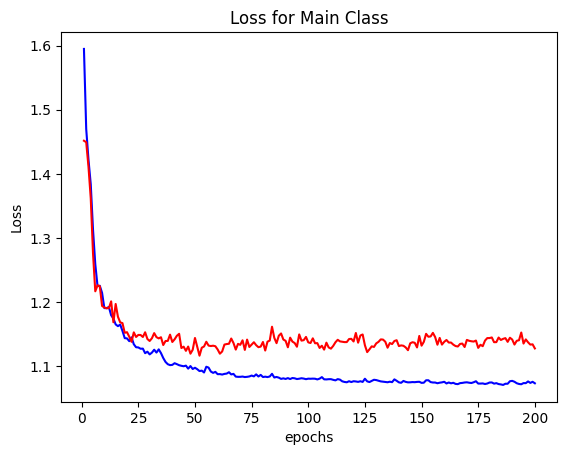

In [ ]:
x = np.arange(1,len(train_loss)+1)
plt.plot(x, train_loss, 'b')
plt.plot(x, test_loss, 'r')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss for Main Class')
plt.show()

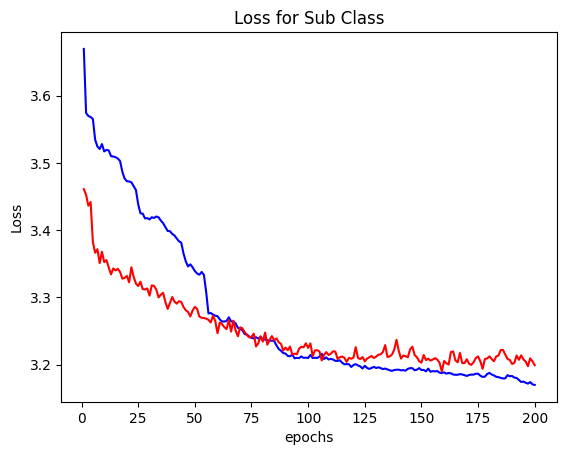

In [ ]:
x = np.arange(1,len(train_loss_sub)+1)
plt.plot(x, train_loss_sub, 'b')
plt.plot(x, test_loss_sub, 'r')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss for Sub Class')
plt.show()

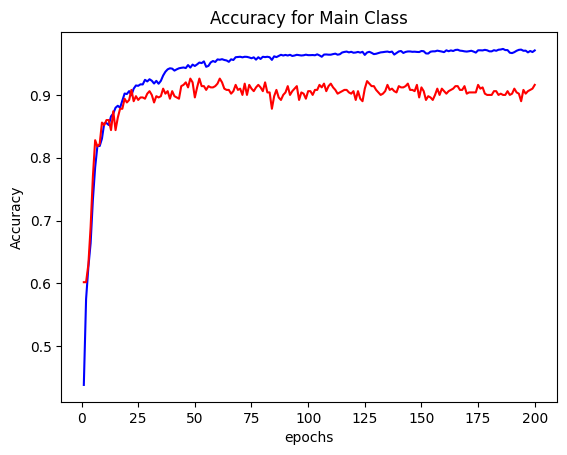

In [ ]:
plt.plot(sparse_epochs, train_acc, 'b')
plt.plot(sparse_epochs, test_acc, 'r')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for Main Class')
plt.show()

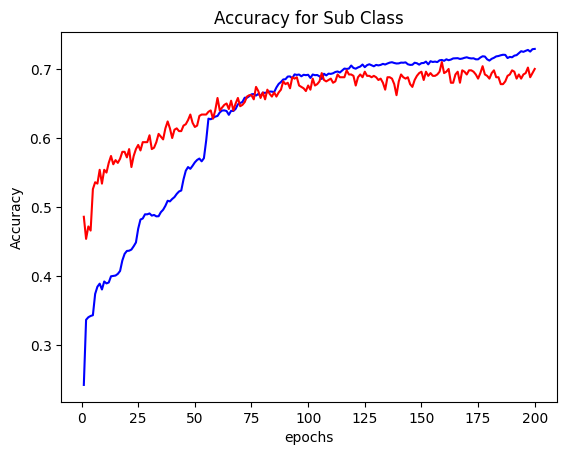

In [ ]:
plt.plot(sparse_epochs, train_acc_sub, 'b')
plt.plot(sparse_epochs, test_acc_sub, 'r')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for Sub Class')
plt.show()

<ipython-input-107-93f8a12bbdd9>:15: RuntimeWarning: invalid value encountered in divide
  df_cm_sub = pd.DataFrame(conf_mat_sub / np.sum(conf_mat_sub, axis=1)[:, None],)


<Axes: >

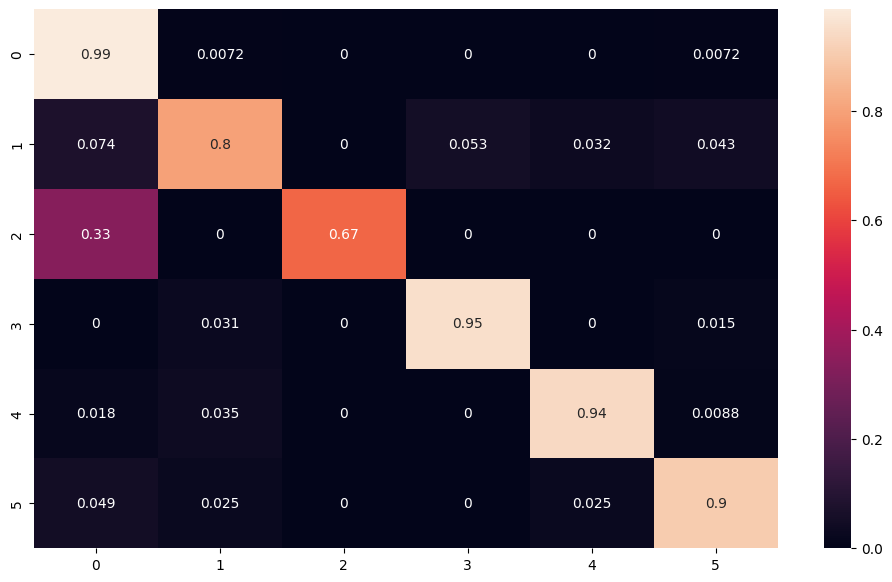

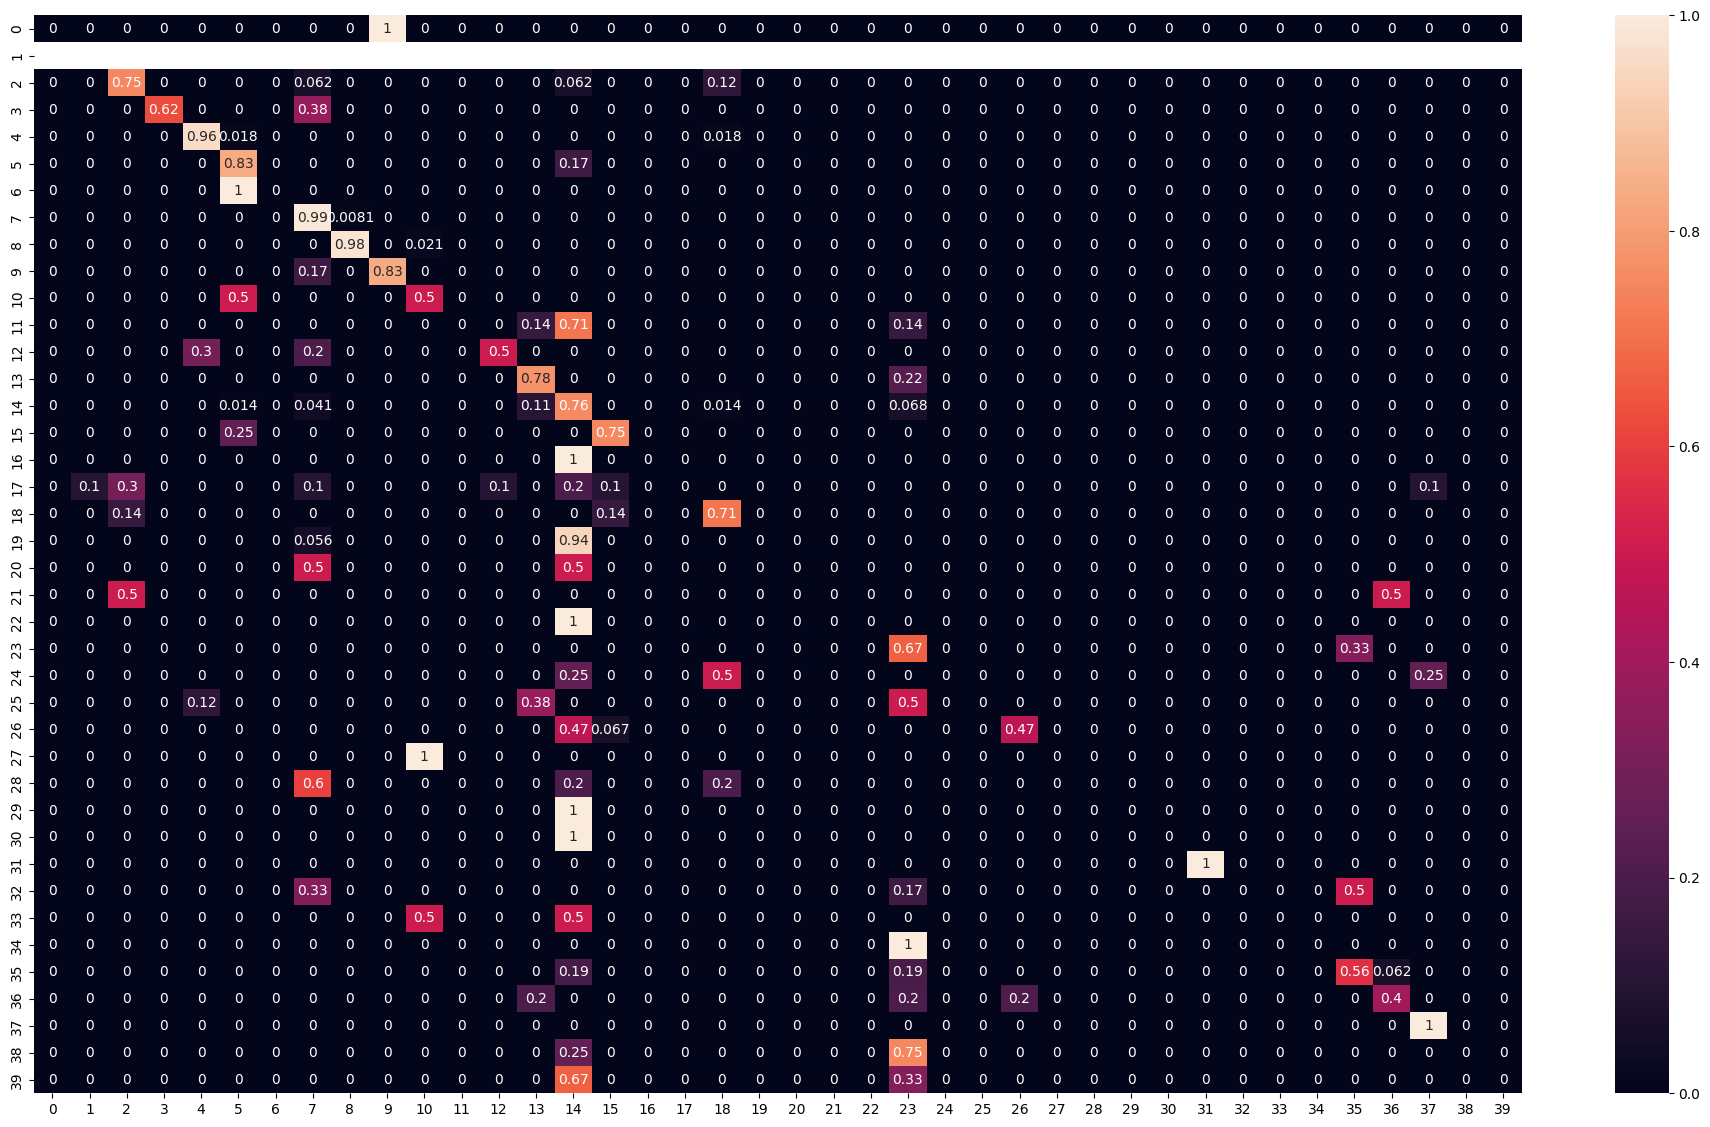

In [ ]:
with torch.inference_mode():
    test_outputs = model_2_100(X_test_tensor)
predictions_b = [torch.argmax(i).detach().cpu().numpy() for i in test_outputs[:,47:]]
predictions_b = np.array(predictions_b)
actual_labels_b =  y_test_tensor[:,0].cpu().numpy()
conf_mat = confusion_matrix(actual_labels_b, predictions_b)
df_cm = pd.DataFrame(conf_mat / np.sum(conf_mat, axis=1)[:, None],)
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

predictions_sub_b = [torch.argmax(i).detach().cpu().numpy() for i in test_outputs[:,:47]]
predictions_sub_b = np.array(predictions_sub_b)
actual_labels_sub_b =  y_test_tensor[:,1].cpu().numpy()
conf_mat_sub = confusion_matrix(actual_labels_sub_b, predictions_sub_b)
df_cm_sub = pd.DataFrame(conf_mat_sub / np.sum(conf_mat_sub, axis=1)[:, None],)
plt.figure(figsize = (24,14))
sn.heatmap(df_cm_sub, annot=True)

In [ ]:
print(classification_report(actual_labels_b, predictions_b))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       138
           1       0.89      0.80      0.84        94
           2       1.00      0.67      0.80         9
           3       0.93      0.95      0.94        65
           4       0.95      0.94      0.95       113
           5       0.91      0.90      0.91        81

    accuracy                           0.92       500
   macro avg       0.93      0.87      0.90       500
weighted avg       0.92      0.92      0.91       500



In [ ]:
print(classification_report(actual_labels_sub_b, predictions_sub_b))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         0
           2       0.71      0.75      0.73        16
           3       1.00      0.62      0.77         8
           4       0.93      0.96      0.95        55
           5       0.50      0.83      0.62         6
           6       0.00      0.00      0.00         1
           7       0.87      0.99      0.93       123
           8       0.98      0.98      0.98        47
           9       0.71      0.83      0.77         6
          10       0.25      0.50      0.33         2
          11       0.00      0.00      0.00         7
          12       0.83      0.50      0.62        10
          13       0.35      0.78      0.48         9
          14       0.51      0.76      0.61        74
          17       0.50      0.75      0.60         4
          18       0.00      0.00      0.00         3
          19       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
torch.save(model_2_100.state_dict(), 'drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/models/model_2_100_ch7.pth')

# model 3

## Preprocessing

In [ ]:
# Create a dictionary of words and their corresponding vectors
path_to_glove_file = 'drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/glove/glove.6B.300d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
correct_dic_single = {'lourve' : 'louvre',
              'dukenfield' : 'duckenfield',}
correct_dic_multi = {'noncellular' : ['non', 'cellular'],
              'poult' : ['baby', 'turkey'],
              'xerophyte' : ['century', 'plant'],
              'mawsynram' : ['town', 'in', 'the', 'east'],}
def remove_special_characters(string):
    return re.sub(r"[^a-zA-Z0-9?]", " ", string)
def sentence_prep(sentence):
    # Tokenize the sentence into individual words
    tokens = word_tokenize(remove_special_characters(sentence))
    # Initialize the WordNetLemmatizer object for lemmatization
    wln = WordNetLemmatizer()
    # Normalize tokenized words by stemming or lemmatization and correct spelling mistakes
    normalized_tokens = []
    for token in tokens:
        normalized_token = wln.lemmatize(token.lower())
        if normalized_token.isnumeric():
            normalized_tokens.extend(normalized_token)
            continue
        if normalized_token in correct_dic_single:
            normalized_tokens.append(correct_dic_single[normalized_token])
            continue
        if normalized_token in correct_dic_multi:
            normalized_tokens.extend(correct_dic_multi[normalized_token])
            continue
        normalized_tokens.append(normalized_token)
    return normalized_tokens

In [ ]:
# Tokenize the data
data_train_3_pd = pd.read_csv('drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/TREC Dataset/QA_data.csv', encoding='latin1')
data_train_3_np = data_train_3_pd.to_numpy()
for row in data_train_3_np:
    row[2] = sentence_prep(row[2])
    row[3] = sentence_prep(row[3])
np.random.shuffle(data_train_3_np)

In [ ]:
# Find and remove unknown words that are not in the GloVe
unknown_words = []
total_words = 0

def find_unknown_words(words):

    global total_words
    total_words = total_words + len(words)
    has_unknown = False
    for word in words:
        if not (word in embeddings_index):
            unknown_words.append(word)
            has_unknown = True
            print(words)
            words.remove(word)
    if has_unknown:
        return words
    return words
for i in range(1):
    unknown_words = []
    total_words = 0
    for row in data_train_3_np:
        find_unknown_words(row[2])
        find_unknown_words(row[3])
    print( f'{len(unknown_words)/total_words*100:5.2} % of train words are unknown' )

  0.0 % of train words are unknown


In [ ]:
# Find how many words are in the longest sentence
longest_inp = 0
for i in range(data_train_3_np.shape[0]):
    length = len(data_train_3_np[i,2])
    if length > longest_inp:
        longest_inp = length
print('for input data the longest sentence has', longest_inp,'words')
longest_trg = 0
for i in range(data_train_3_np.shape[0]):
    length = len(data_train_3_np[i,3])
    if length > longest_trg:
        longest_trg = length
print('for target data the longest sentence has', longest_trg,'words')

for input data the longest sentence has 20 words
for target data the longest sentence has 9 words


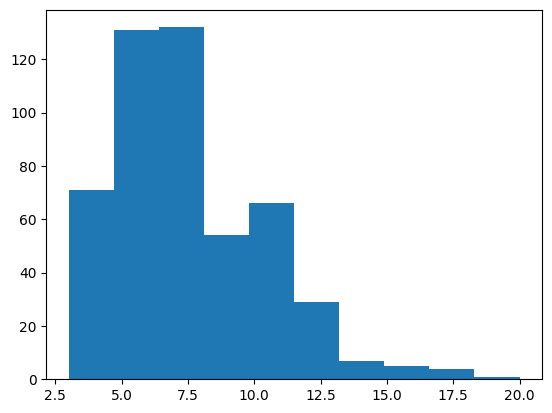

for input sentences; median = 7.0 min = 3.0 max = 20.0


In [ ]:
# Create a histogram of the length of the input sentences
lengths = np.zeros(data_train_3_np.shape[0])
for i in range(data_train_3_np.shape[0]):
    lengths[i] = len(data_train_3_np[i,2])

plt.hist(lengths)
plt.show()
median = np.median(lengths)
print('for input sentences; median =', median,'min =',np.min(lengths),'max =',np.max(lengths))

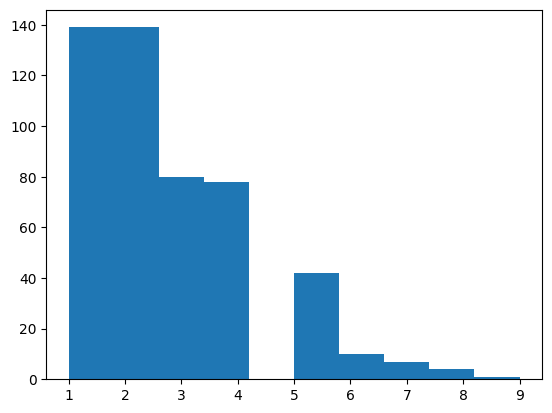

for target sentences; median = 2.0 min = 1.0 max = 9.0


In [ ]:
# Create a histogram of the length of the target sentences
lengths = np.zeros(data_train_3_np.shape[0])
for i in range(data_train_3_np.shape[0]):
    lengths[i] = len(data_train_3_np[i,3])

plt.hist(lengths)
plt.show()
median = np.median(lengths)
print('for target sentences; median =', median,'min =',np.min(lengths),'max =',np.max(lengths))

In [ ]:
device = 'cuda'
torch.cuda.empty_cache()

In [ ]:
# Convert train data to tensor
X_train = np.zeros((data_train_3_np.shape[0],int(longest_inp),300))
answers_data = np.zeros((data_train_3_np.shape[0],int(longest_inp),300))
answer_bound = np.zeros((data_train_3_np.shape[0],2), dtype=int)
y_train = np.zeros((data_train_3_np.shape[0],2))
# Put all the words used in the input and target sentences into a set
all_used_words = {'0','1','2','3','4','5','6','7','8','9'}
for i in range(data_train_3_np.shape[0]):
    words = np.array(list(map(lambda i: embeddings_index[i], data_train_3_np[i,2])))
    answer = np.array(list(map(lambda i: embeddings_index[i], data_train_3_np[i,3])))
    all_used_words.update(data_train_3_np[i,2])
    all_used_words.update(data_train_3_np[i,3])
    if len(words) > len(answer):
        X_train[i,-len(words):,:] = words[-int(longest_inp):]
        answers_data[i,-len(words):-len(words)+len(answer),:] = answer
        answer_bound[i,0] = -len(words)
        answer_bound[i,1] = -len(words)+len(answer)
    elif len(words) < len(answer):
        X_train[i,-len(answer):-len(answer)+len(words),:] = words[-int(longest_inp):]
        answers_data[i,-len(answer):,:] = answer
        answer_bound[i,0] = -len(answer)
        answer_bound[i,1] = 1000
    else:
        X_train[i,-len(words):,:] = words[-int(longest_inp):]
        answers_data[i,-len(answer):,:] = answer
        answer_bound[i,0] = -len(answer)
        answer_bound[i,1] = 1000
    y_train[i,0] = data_train_3_np[i,0]
    y_train[i,1] = data_train_3_np[i,1]
X_train_3_tensor = torch.tensor(X_train, device=device, dtype=torch.float)
answers_data_tensor = torch.tensor(answers_data, device=device, dtype=torch.float)
y_train_3_tensor = torch.tensor(y_train, device=device, dtype=torch.long)

In [ ]:
# Count the number of data in each main class
unique, counts = np.unique(data_train_3_np[:,0], return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4, 5], dtype=object),
 array([138,  94,   9,  65, 113,  81]))

In [ ]:
# Count the number of data in each sub class
unique_sub, counts_sub = np.unique(data_train_3_np[:,1], return_counts=True)
unique_sub, counts_sub

(array([0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 37, 38, 40, 41,
        44, 45, 46], dtype=object),
 array([  2,  16,   8,  55,   6,   1, 123,  47,   6,   2,   7,  10,   9,
         74,   4,   3,  10,   7,  18,   2,   2,   3,   3,   4,   8,  15,
          1,   5,   1,   1,   1,   6,   2,   3,  16,   5,   4,   4,   6]))

In [ ]:
# Add a padding vector at the end of the input tensors
X_train_3_sub_tensor = torch.zeros((X_train_3_tensor.shape[0],X_train_3_tensor.shape[1]+1,X_train_3_tensor.shape[2],),
                                   dtype=X_train_3_tensor.dtype)
pad_train_3 = torch.zeros((1,300), dtype=X_train_3_tensor.dtype,device=X_train_3_tensor.device)
for i in range(len(X_train_3_tensor)):
    X_train_3_sub_tensor[i] = torch.concat((X_train_3_tensor[i],pad_train_3))

In [ ]:
# find nearest words in the embedding to the predicted words in the output sentences
def tensor2words(tensor, embeddings_keys, embeddings_values):
    inp = tensor.detach().cpu().numpy()
    output = np.zeros(inp.shape[:2], dtype='U15')
    for sentence_num in range(inp.shape[0]):
        for word_num in range(inp.shape[1]):
            wordvec = inp[sentence_num, word_num]
            idx = np.argmin(((embeddings_values - wordvec)**2).mean(axis=1))
            output[sentence_num, word_num] = embeddings_keys[idx]
    return output

In [ ]:
# Create an array of words used in the dataset and another array of vectors used in the dataset
embeddings_used_keys = np.array(list(all_used_words))
embeddings_used_values = np.zeros((len(all_used_words),300))
for i, word in enumerate(embeddings_used_keys):
    embeddings_used_values[i] = embeddings_index[word]
embeddings_used_keys.shape, embeddings_used_values.shape

((1522,), (1522, 300))

## Training

### h = 25

In [ ]:
class LSTMNetwork3_25(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = 1
        self.lstm = nn.LSTM(self.input_size, self.hidden_size
                            , self.num_layers, batch_first=True)
        self.classifier = nn.Sequential( nn.Linear(self.hidden_size, 128)
                                        ,nn.ReLU()
                                        ,nn.Linear(128, 32)
                                        ,nn.ReLU()
                                        ,nn.Linear(32, 6))
        self.classifier2 = nn.Sequential( nn.Linear(self.hidden_size, 256)
                                        ,nn.ReLU()
                                        ,nn.Linear(256, 64)
                                        ,nn.ReLU()
                                        ,nn.Linear(64, 47))
        self.softmax = nn.Softmax(-1)
        self.lstm2 = nn.LSTM(self.input_size, 300,
                             self.num_layers, batch_first=True, bidirectional=True)
        self.linear_after_bilstm = nn.Linear(300*2, 300)
    def forward(self, inp):
        output, (hidden, _) = self.lstm(inp)
        x = output[:,-2,:]
        y = output[:,-1,:]
        concat = torch.concat((y,x),dim=1)
        h_0_s = torch.concat((concat,concat,concat,concat,concat,concat), dim=1)
        h_0 = torch.concat((h_0_s.unsqueeze(0), h_0_s.unsqueeze(0)),dim=0)
        bilstm_out, _ = self.lstm2(inp[:,:-1,:],(h_0, h_0))
        words_tensor = self.linear_after_bilstm(bilstm_out)
        return words_tensor

In [ ]:
torch.cuda.empty_cache()


hidden_size = 25
input_size = 300
num_layers = 1
lr = 0.001
batch_size = 50
torch.manual_seed(40)
# Initialize the model, the optimizer and criterion
model_3_25 = LSTMNetwork3_25(input_size, hidden_size)
model_3_25.load_state_dict(torch.load('drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/models/model_2_25_ch7.pth'), strict=False)
for name, para in model_3_25.lstm.named_parameters():
    para.requires_grad = False
for name, para in model_3_25.classifier.named_parameters():
    para.requires_grad = False
for name, para in model_3_25.classifier2.named_parameters():
    para.requires_grad = False

model_3_25 = model_3_25.to(device)
optimizer = optim.Adam(model_3_25.parameters(), lr=lr)
criterion = nn.MSELoss()

train_loss = np.zeros((0))
train_acc = np.zeros((0))
test_loss = np.zeros((0))
test_acc = np.zeros((0))
total_epoch_counter = 0
total_epoch = 0
sparse_epochs = np.zeros((0))
loader_size = len(X_train_3_tensor)//batch_size

In [ ]:
num_epochs = 200
total_epoch += num_epochs
train_loss = np.concatenate((train_loss, np.zeros((num_epochs))), )
test_loss = np.concatenate((test_loss, np.zeros((num_epochs))), )
train_acc = np.concatenate((train_acc, np.zeros((num_epochs))), )
test_acc = np.concatenate((test_acc, np.zeros((num_epochs))), )
sparse_epochs = np.concatenate((sparse_epochs, np.zeros((num_epochs))), )

for epoch in range(num_epochs):
    model_3_25.train()
    total_loss = 0
    loss = torch.tensor([0.0],device=device)
    optimizer.zero_grad()
    for i in range(len(X_train_3_sub_tensor)):
        input_data = X_train_3_sub_tensor[i:(i+1)]
        target = answers_data_tensor[i:(i+1)]
        outputs = model_3_25(input_data.to(device))
        loss += criterion(outputs, target.to(device))
        if (i+1) % batch_size == 0:
            loss /= batch_size
            loss.backward()
            optimizer.step()
            total_loss += loss
            optimizer.zero_grad()
            loss = torch.tensor([0.0],device=device)
    total_loss /= loader_size
    train_loss[total_epoch_counter] = total_loss.detach().cpu().numpy()
    if (epoch+1) % 10 == 0:
        print('Epoch [{}/{}], Train loss: {:.7f}, lr: {:.4f}'
               .format(total_epoch_counter+1, total_epoch, train_loss[total_epoch_counter], lr))
    total_epoch_counter += 1

Epoch [10/200], Train loss: 0.0135025, lr: 0.0010
Epoch [20/200], Train loss: 0.0113701, lr: 0.0010
Epoch [30/200], Train loss: 0.0088381, lr: 0.0010
Epoch [40/200], Train loss: 0.0074625, lr: 0.0010
Epoch [50/200], Train loss: 0.0060425, lr: 0.0010
Epoch [60/200], Train loss: 0.0051959, lr: 0.0010
Epoch [70/200], Train loss: 0.0043536, lr: 0.0010
Epoch [80/200], Train loss: 0.0040617, lr: 0.0010
Epoch [90/200], Train loss: 0.0033803, lr: 0.0010
Epoch [100/200], Train loss: 0.0031539, lr: 0.0010
Epoch [110/200], Train loss: 0.0025109, lr: 0.0010
Epoch [120/200], Train loss: 0.0024312, lr: 0.0010
Epoch [130/200], Train loss: 0.0020979, lr: 0.0010
Epoch [140/200], Train loss: 0.0021241, lr: 0.0010
Epoch [150/200], Train loss: 0.0017405, lr: 0.0010
Epoch [160/200], Train loss: 0.0017377, lr: 0.0010
Epoch [170/200], Train loss: 0.0014811, lr: 0.0010
Epoch [180/200], Train loss: 0.0013835, lr: 0.0010
Epoch [190/200], Train loss: 0.0013605, lr: 0.0010
Epoch [200/200], Train loss: 0.0012123, 

#### Sample questions

In [ ]:
def question_to_answer(question, model):
  test_sentence_tokens = sentence_prep(question)
  test_sentence_tensor = torch.tensor(np.array(list(map(lambda i: embeddings_index[i], test_sentence_tokens))))
  test_sentence_tensor = test_sentence_tensor.unsqueeze(0)
  prediction_tensors = model(test_sentence_tensor.to(device))
  words = tensor2words(prediction_tensors, embeddings_used_keys, embeddings_used_values)
  words = words.squeeze().tolist()
  answer = []
  for item in words:
    if item == 'same' and len(answer) == 0:
      continue
    elif item == 'same':
      break
    else:
      answer.append(item)
  return ' '.join(answer)


In [ ]:
question = 'How many people speak French?'
question_to_answer(question, model_3_25)

'5 leaving'

In [ ]:
question = 'What day is today?'
question_to_answer(question, model_3_25)

'2 dec'

In [ ]:
question = 'Who will win the war?'
question_to_answer(question, model_3_25)

'wilson evans and leaving leaving'

In [ ]:
question = 'Who is Italian first minister?'
question_to_answer(question, model_3_25)

'populate populate'

In [ ]:
question = 'When World War II ended?'
question_to_answer(question, model_3_25)

'1 5'

In [ ]:
question = 'When Gandhi was assassinated?'
question_to_answer(question, model_3_25)

'1 3 7'

### h = 100

In [ ]:
class LSTMNetwork3_100(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = 1
        self.lstm = nn.LSTM(self.input_size, self.hidden_size
                            , self.num_layers, batch_first=True)
        self.classifier = nn.Sequential( nn.Linear(self.hidden_size, 128)
                                        ,nn.ReLU()
                                        ,nn.Linear(128, 32)
                                        ,nn.ReLU()
                                        ,nn.Linear(32, 6))
        self.classifier2 = nn.Sequential( nn.Linear(self.hidden_size, 256)
                                        ,nn.ReLU()
                                        ,nn.Linear(256, 64)
                                        ,nn.ReLU()
                                        ,nn.Linear(64, 47))
        self.softmax = nn.Softmax(-1)
        self.lstm2 = nn.LSTM(self.input_size, 300,
                             self.num_layers, batch_first=True, bidirectional=True)
        self.linear_after_bilstm = nn.Linear(300*2, 300)
    def forward(self, inp):
        output, (hidden, _) = self.lstm(inp)
        x = output[:,-2,:]
        y = output[:,-1,:]
        concat = torch.concat((y,x),dim=1)
        mean = torch.mean(concat,1).unsqueeze(-1)
        filler = torch.concat((mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,
                               mean,mean,mean,mean,mean,mean,mean,mean,mean), dim=1)
        h_0_s = torch.concat((concat,filler,filler,filler,filler,filler), dim=1)
        h_0 = torch.concat((h_0_s.unsqueeze(0), h_0_s.unsqueeze(0)),dim=0)
        bilstm_out, _ = self.lstm2(inp[:,:-1,:],(h_0, h_0))
        words_tensor = self.linear_after_bilstm(bilstm_out)
        return words_tensor

In [ ]:
torch.cuda.empty_cache()

hidden_size = 100
input_size = 300
lr = 0.001
batch_size = 50
torch.manual_seed(41)
# Initialize the model, the optimizer and criterion
model_3_100 = LSTMNetwork3_100(input_size, hidden_size)
model_3_100.load_state_dict(torch.load('drive/MyDrive/Colab Notebooks/DNN_HW4_Q2/models/model_2_100_ch7.pth'), strict=False)
for name, para in model_3_100.lstm.named_parameters():
    para.requires_grad = False
for name, para in model_3_100.classifier.named_parameters():
    para.requires_grad = False
for name, para in model_3_100.classifier2.named_parameters():
    para.requires_grad = False

model_3_100 = model_3_100.to(device)
optimizer = optim.Adam(model_3_100.parameters(), lr=lr)
criterion = nn.MSELoss()

train_loss = np.zeros((0))
train_acc = np.zeros((0))
test_loss = np.zeros((0))
test_acc = np.zeros((0))
total_epoch_counter = 0
total_epoch = 0
sparse_epochs = np.zeros((0))
loader_size = len(X_train_3_tensor)//batch_size

In [ ]:
num_epochs = 200
total_epoch += num_epochs
train_loss = np.concatenate((train_loss, np.zeros((num_epochs))), )
test_loss = np.concatenate((test_loss, np.zeros((num_epochs))), )
train_acc = np.concatenate((train_acc, np.zeros((num_epochs))), )
test_acc = np.concatenate((test_acc, np.zeros((num_epochs))), )
sparse_epochs = np.concatenate((sparse_epochs, np.zeros((num_epochs))), )

for epoch in range(num_epochs):
    model_3_100.train()
    total_loss = 0
    loss = torch.tensor([0.0],device=device)
    optimizer.zero_grad()
    for i in range(len(X_train_3_sub_tensor)):
        input_data = X_train_3_sub_tensor[i:(i+1)]
        target = answers_data_tensor[i:(i+1)]
        outputs = model_3_100(input_data.to(device))
        loss += criterion(outputs, target.to(device))

        if (i+1) % batch_size == 0:
            loss /= batch_size
            loss.backward()
            optimizer.step()
            total_loss += loss
            optimizer.zero_grad()
            loss = torch.tensor([0.0],device=device)
    total_loss /= loader_size
    train_loss[total_epoch_counter] = total_loss.detach().cpu().numpy()
    if (epoch+1) % 10 == 0:
        print('Epoch [{}/{}], Train loss: {:.7f}, lr: {:.4f}'
               .format(total_epoch_counter+1, total_epoch, train_loss[total_epoch_counter], lr))
    total_epoch_counter += 1

Epoch [10/200], Train loss: 0.0134525, lr: 0.0010
Epoch [20/200], Train loss: 0.0111124, lr: 0.0010
Epoch [30/200], Train loss: 0.0088021, lr: 0.0010
Epoch [40/200], Train loss: 0.0071665, lr: 0.0010
Epoch [50/200], Train loss: 0.0061393, lr: 0.0010
Epoch [60/200], Train loss: 0.0050729, lr: 0.0010
Epoch [70/200], Train loss: 0.0042586, lr: 0.0010
Epoch [80/200], Train loss: 0.0037654, lr: 0.0010
Epoch [90/200], Train loss: 0.0032952, lr: 0.0010
Epoch [100/200], Train loss: 0.0029072, lr: 0.0010
Epoch [110/200], Train loss: 0.0025882, lr: 0.0010
Epoch [120/200], Train loss: 0.0025027, lr: 0.0010
Epoch [130/200], Train loss: 0.0020361, lr: 0.0010
Epoch [140/200], Train loss: 0.0018843, lr: 0.0010
Epoch [150/200], Train loss: 0.0017713, lr: 0.0010
Epoch [160/200], Train loss: 0.0017663, lr: 0.0010
Epoch [170/200], Train loss: 0.0014372, lr: 0.0010
Epoch [180/200], Train loss: 0.0013996, lr: 0.0010
Epoch [190/200], Train loss: 0.0013044, lr: 0.0010
Epoch [200/200], Train loss: 0.0012205, 

#### Sample questions

In [ ]:
question = 'How many people speak French?'
question_to_answer(question, model_3_100)

'5 leaving'

In [ ]:
question = 'What day is today?'
question_to_answer(question, model_3_100)

'4 dec'

In [ ]:
question = 'Who will win the war?'
question_to_answer(question, model_3_100)

'evans evans carlson leaving'

In [ ]:
question = 'Who is Italian first minister?'
question_to_answer(question, model_3_100)

'toni wilson'

In [ ]:
question = 'When World War II ended?'
question_to_answer(question, model_3_100)

'5 9 5 leaving leaving'

In [ ]:
question = 'When Gandhi was assassinated?'
question_to_answer(question, model_3_100)

'1 5 9'